In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import pickle

from scipy.stats.mstats import gmean

from cnp.cnp import StandardPredPreyConvGNP, FullConvGNP
from cnp.cov import (
    MeanFieldGaussianLayer,
    InnerprodGaussianLayer,
    KvvGaussianLayer,
    ExponentialCopulaLayer
)
from cnp.lnp import StandardPredPreyConvNP

import stheno
from shutil import copyfile

from collections import OrderedDict

from itertools import product

import matplotlib

from cnp.experiment import WorkingDirectory
from cnp.data import PredatorPreyGenerator
# matplotlib.rcParams['text.usetex'] = True

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

In [ ]:
args_num_basis_dim = 32
args_jitter = 1e-4

In [ ]:
def load_model(model_name, device, working_directory):
    
    if 'convgnp' in model_name and not('fullconvgnp' in model_name):
        
        output_layer = None

        if 'meanfield' in model_name:
            output_layer = MeanFieldGaussianLayer()

        elif 'innerprod' in model_name:
            output_layer = InnerprodGaussianLayer(num_embedding=args_num_basis_dim,
                                                  noise_type='hetero',
                                                  jitter=args_jitter)

        elif 'kvv' in model_name:
            output_layer = KvvGaussianLayer(num_embedding=args_num_basis_dim,
                                            noise_type='hetero',
                                            jitter=args_jitter)

        if 'exponential' in model_name:
            output_layer = ExponentialCopulaLayer(gaussian_layer=output_layer,
                                                  device=device)

        model = StandardPredPreyConvGNP(input_dim=1,
                                        output_layer=output_layer)
        
    elif 'convnp' in model_name:
        model = StandardPredPreyConvNP(input_dim=1, num_samples=16)

    elif 'fullconvgnp' in model_name:
        model = FullConvGNP(points_per_unit_mean=16,
                            points_per_unit_kernel=8)

    # Load model to appropriate device
    model = model.to(device)

    # Load model from saved state
    load_dict = torch.load(working_directory.file(f'{model_name}', exists=True), map_location=torch.device('cpu'))
    model.load_state_dict(load_dict['state_dict'])
    
    return model

In [ ]:
# root = '../../experiments/predator-prey/results'
# data = 'sim-pred-prey-100-16-50-100-100-0'

# copyfile(f'{root}/{data}/models/convGNP/meanfield/hetero/identity/seed-0/model_best.pth.tar', 'models/convgnp-meanfield-identity')
# copyfile(f'{root}/{data}/models/convGNP/innerprod/hetero/identity/seed-0/model_best.pth.tar', 'models/convgnp-innerprod-identity')
# copyfile(f'{root}/{data}/models/convGNP/kvv/hetero/identity/seed-0/model_best.pth.tar', 'models/convgnp-kvv-identity')

# copyfile(f'{root}/{data}/models/convGNP/meanfield/hetero/exponential/seed-0/model_best.pth.tar', 'models/convgnp-meanfield-exponential')
# copyfile(f'{root}/{data}/models/convGNP/innerprod/hetero/exponential/seed-0/model_best.pth.tar', 'models/convgnp-innerprod-exponential')
# copyfile(f'{root}/{data}/models/convGNP/kvv/hetero/exponential/seed-0/model_best.pth.tar', 'models/convgnp-kvv-exponential')

# copyfile(f'{root}/{data}/models/convNP/meanfield/homo/identity/seed-0/model_best.pth.tar', 'models/convnp-identity')
# copyfile(f'{root}/{data}/models/FullConvGNP/meanfield/homo/identity/seed-0/model_best.pth.tar', 'models/fullconvgnp-identity')

copyfile(f'../../experiments/predator-prey/simulated-data/sim-pred-prey-100-16-50-100-100-0/test-data.pkl', 'data.pkl')

model_directory = WorkingDirectory('/scratches/cblgpu07/em626/kernelcnp/kernelcnp/notebooks/pred-prey-results/models')
# model_directory = WorkingDirectory('/Users/stratis/repos/kernelcnp/kernelcnp/notebooks/pred-prey-results/models')
device = torch.device('cpu')

# Load data

In [ ]:
file = open('data.pkl', 'rb')
batch = pickle.load(file)[0][1]
file.close()

device = torch.device('cpu')

x_context = batch['x_context'][:1, :, None].to(device)
y_context = batch['y_context'][:1, 0, :, None].to(device) / 100 + 1e-2
x_target = batch['x_target'][:1, :, None].to(device)
y_target = batch['y_target'][:1, 0, :, None].to(device) / 100 + 1e-2


x_context = x_context[:, ::5, :][:, :x_context.shape[1]//2, :]
y_context = y_context[:, ::5, :][:, :y_context.shape[1]//2, :]
x_target = x_target[:, :, :]
y_target = y_target[:, :, :]


x_context = torch.cat([x_context[:, :4, :], x_context[:, 5:, :]], axis=1)
y_context = torch.cat([y_context[:, :4, :], y_context[:, 5:, :]], axis=1)

# Posterior plots

In [ ]:
models = [
    ('ConvGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-identity'),
    ('ConvGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-identity'),
    ('ConvGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-identity'),
    ('ConvNP', StandardPredPreyConvNP, 'convnp-identity'),
    ('ConvCGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-exponential'),
    ('ConvCGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-exponential'),
    ('ConvCGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-exponential'),
    ('FullConvGNP', FullConvGNP, 'fullconvgnp-identity'),
]

In [ ]:
num_noisy_samples = 256
num_noiseless_samples = 2

x_plot = torch.linspace(-5., 55., 200)[None, :, None].to(device)

fig = plt.figure(figsize=(16, 6))

for i, (model_title, model_class, model_name) in enumerate(models):
    
    plt.subplot(2, 4, i+1)
    
    # Load model
    model = load_model(model_name, device=device, working_directory=model_directory)
    
    # Draw samples (noisy and noiseless)
    samples = model.sample(x_context,
                           y_context,
                           x_plot,
                           num_samples=num_noisy_samples,
                           noiseless=False,
                           double=True)
    
    # Plot data and samples
    plt.plot(to_numpy(x_plot[0, :, 0]),
             to_numpy(samples[:, 0, :]).T,
             color='tab:blue',
             alpha=0.01,
             zorder=1,
             label='Noisy samples')
    
    samples = model.sample(x_context,
                           y_context,
                           x_plot,
                           num_samples=num_noiseless_samples,
                           noiseless=True,
                           double=True)
    
    # Plot data and samples
    
    if not (model_name == 'convgnp-meanfield-identity' or \
            model_name == 'convgnp-meanfield-exponential'):
        plt.plot(to_numpy(x_plot[0, :, 0]),
                 to_numpy(samples[:, 0, :]).T,
                 color='tab:green',
                 alpha=1.0,
                 zorder=2,
                 linewidth=2,
                 label='Noiseless samples')
    
    plt.scatter(to_numpy(x_context)[0, :, 0],
                to_numpy(y_context)[0, :, 0],
                color='black',
                marker='+',
                s=50,
                zorder=4,
                label='Context')
    
    plt.scatter(to_numpy(x_target)[0, :, 0],
                to_numpy(y_target)[0, :, 0],
                color='red',
                marker='+',
                s=20,
                zorder=3,
                label='Target')
    
    plt.xlim([-5, 55])
    plt.ylim([-0.5, 4.5])
    
    if i < 4:
        plt.xticks([])
    else:
        plt.xticks(np.linspace(0, 50, 6), fontsize=18)
        plt.xlabel('$x$', fontsize=22)
    
    if i % 4 != 0:
        plt.yticks([])
        
    else:
        plt.yticks(np.linspace(0, 4, 3), fontsize=18)
        plt.ylabel('$y$', fontsize=22)
        
    plt.plot([-5., 55.], [0., 0.], '--', color='black', zorder=1)
        
    plt.title(model_title, fontsize=24)
    
handles, labels = plt.gca().get_legend_handles_labels()

# fig.legend(handles[-4:], labels[-4:], loc='center', ncol=1, fontsize=15, bbox_to_anchor=(1.0, 0.0, 0.5, 1.1), handletextpad=0.01, columnspacing=2.0)
plt.tight_layout()
plt.savefig('pred-prey-plots.pdf')
plt.show()

In [ ]:
models = [
    ('ConvGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-identity'),
    ('ConvCGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-exponential'),
    ('ConvGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-identity'),
    ('ConvCGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-exponential'),
    ('ConvGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-identity'),
    ('ConvCGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-exponential'),
    ('ConvNP', StandardPredPreyConvNP, 'convnp-identity'),
    ('FullConvGNP', FullConvGNP, 'fullconvgnp-identity'),
]

In [ ]:
num_noisy_samples = 256
num_noiseless_samples = 2

x_plot = torch.linspace(-5., 55., 200)[None, :, None].to(device)

fig = plt.figure(figsize=(8, 8))

for i, (model_title, model_class, model_name) in enumerate(models):
    
    plt.subplot(4, 2, i+1)
    
    # Load model
    model = load_model(model_name, device=device, working_directory=model_directory)
    
    # Draw samples (noisy and noiseless)
    samples = model.sample(x_context,
                           y_context,
                           x_plot,
                           num_samples=num_noisy_samples,
                           noiseless=False,
                           double=True)
    
    # Plot data and samples
    plt.plot(to_numpy(x_plot[0, :, 0]),
             to_numpy(samples[:, 0, :]).T,
             color='tab:blue',
             alpha=0.01,
             zorder=1,
             label='Noisy samples')
    
    samples = model.sample(x_context,
                           y_context,
                           x_plot,
                           num_samples=num_noiseless_samples,
                           noiseless=True,
                           double=True)
    
    # Plot data and samples
    
    if not (model_name == 'convgnp-meanfield-identity' or \
            model_name == 'convgnp-meanfield-exponential'):
        plt.plot(to_numpy(x_plot[0, :, 0]),
                 to_numpy(samples[:, 0, :]).T,
                 color='tab:green',
                 alpha=1.0,
                 zorder=2,
                 linewidth=2,
                 label='Noiseless samples')
    
    plt.scatter(to_numpy(x_context)[0, :, 0],
                to_numpy(y_context)[0, :, 0],
                color='black',
                marker='+',
                s=50,
                zorder=4,
                label='Context')
    
    plt.scatter(to_numpy(x_target)[0, :, 0],
                to_numpy(y_target)[0, :, 0],
                color='red',
                marker='+',
                s=20,
                zorder=3,
                label='Target')
    
    plt.xlim([-5, 55])
    plt.ylim([-0.5, 4.5])
    
    if i < 6:
        plt.xticks([])
    else:
        plt.xticks(np.linspace(0, 50, 6), fontsize=18)
        plt.xlabel('$x$', fontsize=22)
    
    if i % 2 != 0:
        plt.yticks([])
        
    else:
        plt.yticks(np.linspace(0, 4, 3), fontsize=18)
        plt.ylabel('$y$', fontsize=22)
        
    plt.plot([-5., 55.], [0., 0.], '--', color='black', zorder=1)
        
    plt.title(model_title, fontsize=24)
    
handles, labels = plt.gca().get_legend_handles_labels()

plt.tight_layout()
plt.savefig('pred-prey-plots-mod.pdf')
plt.show()

In [78]:
from scipy.interpolate import interp1d

def threshold_estimator(data, model, coefficient, num_samples, max_num_context, max_num_target, num_grid, noiseless):

    true_event_probs = []
    log_probs = []
    
    probs_all = torch.zeros(size=(0,))
    true_events_all = torch.zeros(size=(0,)).long()
    
    with torch.no_grad():
        for epoch in data:

            for i, batch in enumerate(epoch):

                x_ctx = batch['x_context'][:, :, None].to(device)
                y_ctx = batch['y_context'][:, 0, :, None].to(device) / 100 + 1e-2
                x_trg = batch['x_all'][:, ::2, None].to(device)
                y_trg = batch['y_all'][:, 0, ::2, None].to(device) / 100 + 1e-2
                
                # Subsample the context set
                num_ctx = batch['x_context'].shape[1]
                _num_ctx = np.random.choice(np.arange(1, max_num_context+1)) if num_ctx > max_num_context else num_ctx
                ctx_idx = torch.randperm(num_ctx)[:_num_ctx]

                x_ctx = x_ctx[:, ctx_idx, :]
                y_ctx = y_ctx[:, ctx_idx, :]

                # Draw posterior samples
                samples = model.sample(x_ctx,
                                       y_ctx,
                                       x_trg,
                                       num_samples=num_samples,
                                       noiseless=noiseless,
                                       double=True)
                
                y_ctx = y_ctx[:, :, 0]
                y_trg = y_trg[:, :, 0]
                
                # Estimate
                max_ctx = torch.max(y_ctx, dim=1)[0]
                max_ctx = max_ctx[:, None].repeat(1, y_trg.shape[1]) # (B, G)
                
                ctx_threshold = coefficient * max_ctx
                event_true = torch.any(ctx_threshold <= y_trg, dim=1)
                
                ctx_threshold = ctx_threshold[None, :, :].repeat(num_samples, 1, 1)
                event_pred = torch.any(ctx_threshold <= samples, dim=2)
                event_pred = torch.mean(event_pred.float(), dim=0)
                event_pred = (1 - 2e-6) * event_pred + 1e-6
                
                log_prob = event_true.float() * torch.log(event_pred) + \
                           (1. - event_true.float()) * torch.log(1. - event_pred)
                
                log_probs.append(log_prob.mean().item())
                true_event_probs.append(torch.mean(event_true.float()).item())
                
                probs_all = torch.cat([probs_all, event_pred], axis=0)
                true_events_all = torch.cat([true_events_all, event_true.long()])
                
#                 if torch.any(torch.logical_not(event_true[0])):

#                     ax = plt.gca()
#                     ax.set_prop_cycle(color=['tab:red', 'tab:green', 'tab:blue'])
                    
#                     plt.plot([x_trg[0, 0, 0],
#                               x_trg[0, -1, 0]],
#                              [ctx_threshold[0, 0, 0], ctx_threshold[0, 0, 0]],
#                              color='k')
#                     plt.scatter(x_ctx[0, :, 0], y_ctx[0, :], c='k')
#                     plt.plot(to_numpy(x_trg[0, :, 0]),
#                              to_numpy(samples[:3, 0, :]).T,
#                              alpha=1.)
#                     plt.show()
                    
#                     print(event_pred[0])
                
                if i % 20 == 0:
                    print(f'{np.mean(log_probs):.3f}, {np.mean(true_event_probs):.3f}')
                    
    return np.mean(log_probs), probs_all, true_events_all

In [79]:
file = open('data.pkl', 'rb')
data = [pickle.load(file)]
file.close()

model = load_model('convgnp-meanfield-identity', device=device, working_directory=model_directory)

mf_logprob, mf_probs_all, mf_true_events_all = threshold_estimator(data,
                                                                   model=model,
                                                                   coefficient=1.1,
                                                                   num_samples=128,
                                                                   max_num_context=20,
                                                                   max_num_target=100,
                                                                   num_grid=300,
                                                                   noiseless=False)
np.save('numpy/mf_logprob.npy', mf_logprob)
np.save('numpy/mf_probs_all.npy', mf_probs_all)
np.save('numpy/mf_true_events_all.npy', mf_true_events_all)

-2.046, 0.750
-0.769, 0.714
-0.711, 0.738
-0.706, 0.736
-0.709, 0.734
-0.695, 0.748
-0.675, 0.750
-0.731, 0.743
-0.752, 0.739
-0.758, 0.741
-0.771, 0.742
-0.761, 0.739
-0.754, 0.743
-0.766, 0.742
-0.782, 0.742
-0.775, 0.746
-0.781, 0.745
-0.781, 0.743
-0.773, 0.743
-0.770, 0.746
-0.771, 0.745
-0.767, 0.745
-0.771, 0.747
-0.769, 0.748
-0.774, 0.747
-0.775, 0.745
-0.773, 0.744
-0.768, 0.743
-0.767, 0.743
-0.767, 0.745
-0.773, 0.744
-0.776, 0.743
-0.770, 0.746
-0.770, 0.746
-0.771, 0.746
-0.777, 0.745
-0.772, 0.744
-0.772, 0.744
-0.768, 0.745
-0.764, 0.747
-0.766, 0.747
-0.763, 0.747
-0.766, 0.747
-0.763, 0.748
-0.766, 0.748
-0.766, 0.749
-0.765, 0.748
-0.765, 0.747
-0.765, 0.746
-0.763, 0.747
-0.765, 0.746
-0.763, 0.746


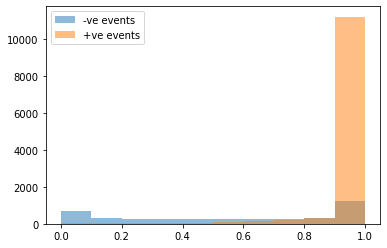

In [80]:
p = mf_probs_all.detach().cpu().numpy()
y = mf_true_events_all.detach().cpu().numpy()

plt.hist(p[np.where(y == 0)], alpha=0.5, label='-ve events')
plt.hist(p[np.where(y == 1)], alpha=0.5, label='+ve events')
plt.legend()
plt.show()

In [81]:
file = open('data.pkl', 'rb')
data = [pickle.load(file)]
file.close()

model = load_model('convgnp-innerprod-identity', device=device, working_directory=model_directory)

ip_logprob, ip_probs_all, ip_true_events_all = threshold_estimator(data,
                                                                   model=model,
                                                                   coefficient=1.1,
                                                                   num_samples=128,
                                                                   max_num_context=20,
                                                                   max_num_target=100,
                                                                   num_grid=300,
                                                                   noiseless=True)
np.save('numpy/ip_logprob.npy', ip_logprob)
np.save('numpy/ip_probs_all.npy', ip_probs_all)
np.save('numpy/ip_true_events_all.npy', ip_true_events_all)

-0.495, 0.625
-0.387, 0.774
-0.360, 0.761
-0.389, 0.742
-0.430, 0.736
-0.452, 0.738
-0.458, 0.746
-0.458, 0.740
-0.470, 0.731
-0.468, 0.735
-0.467, 0.735
-0.467, 0.737
-0.467, 0.742
-0.469, 0.741
-0.468, 0.742
-0.467, 0.744
-0.468, 0.745
-0.466, 0.743
-0.468, 0.744
-0.465, 0.745
-0.468, 0.743
-0.471, 0.743
-0.470, 0.745
-0.469, 0.747
-0.472, 0.746
-0.468, 0.745
-0.466, 0.745
-0.466, 0.744
-0.462, 0.747
-0.461, 0.747
-0.461, 0.746
-0.460, 0.744
-0.460, 0.746
-0.459, 0.746
-0.459, 0.747
-0.459, 0.746
-0.460, 0.747
-0.461, 0.746
-0.463, 0.746
-0.462, 0.748
-0.460, 0.748
-0.460, 0.747
-0.462, 0.748
-0.462, 0.748
-0.462, 0.749
-0.464, 0.751
-0.466, 0.751
-0.467, 0.751
-0.467, 0.751
-0.467, 0.752
-0.468, 0.752
-0.468, 0.750


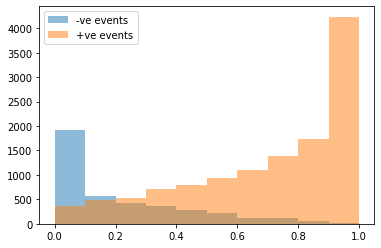

In [82]:
p = ip_probs_all.detach().cpu().numpy()
y = ip_true_events_all.detach().cpu().numpy()

plt.hist(p[np.where(y == 0)], alpha=0.5, label='-ve events')
plt.hist(p[np.where(y == 1)], alpha=0.5, label='+ve events')
plt.legend()
plt.show()

In [83]:
file = open('data.pkl', 'rb')
data = [pickle.load(file)]
file.close()

model = load_model('convgnp-kvv-identity', device=device, working_directory=model_directory)

kvv_logprob, kvv_probs_all, kvv_true_events_all = threshold_estimator(data,
                                                            model=model,
                                                            coefficient=1.1,
                                                            num_samples=128,
                                                            max_num_context=20,
                                                            max_num_target=100,
                                                            num_grid=300,
                                                            noiseless=True)
np.save('numpy/kvv_logprob.npy', kvv_logprob)
np.save('numpy/kvv_probs_all.npy', kvv_probs_all)
np.save('numpy/kvv_true_events_all.npy', kvv_true_events_all)

-0.444, 0.375
-0.372, 0.696
-0.371, 0.720
-0.373, 0.697
-0.360, 0.719
-0.353, 0.730
-0.344, 0.736
-0.341, 0.733
-0.345, 0.730
-0.338, 0.738
-0.335, 0.736
-0.339, 0.737
-0.341, 0.735
-0.341, 0.732
-0.339, 0.734
-0.335, 0.735
-0.336, 0.734
-0.335, 0.736
-0.334, 0.737
-0.335, 0.738
-0.337, 0.737
-0.339, 0.740
-0.338, 0.741
-0.336, 0.742
-0.334, 0.744
-0.337, 0.741
-0.336, 0.740
-0.336, 0.741
-0.335, 0.741
-0.330, 0.744
-0.331, 0.743
-0.330, 0.742
-0.329, 0.745
-0.329, 0.746
-0.328, 0.749
-0.329, 0.748
-0.329, 0.748
-0.329, 0.748
-0.329, 0.748
-0.331, 0.748
-0.332, 0.748
-0.331, 0.747
-0.330, 0.747
-0.330, 0.749
-0.330, 0.748
-0.331, 0.749
-0.332, 0.749
-0.332, 0.748
-0.331, 0.749
-0.331, 0.749
-0.331, 0.749
-0.333, 0.748


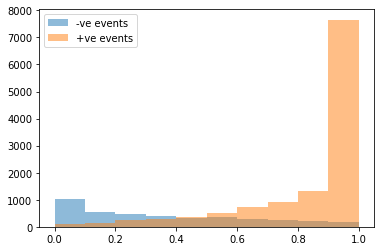

In [84]:
p = kvv_probs_all.detach().cpu().numpy()
y = kvv_true_events_all.detach().cpu().numpy()

plt.hist(p[np.where(y == 0)], alpha=0.5, label='-ve events')
plt.hist(p[np.where(y == 1)], alpha=0.5, label='+ve events')
plt.legend()
plt.show()

In [85]:
file = open('data.pkl', 'rb')
data = [pickle.load(file)]
file.close()

model = load_model('convnp-identity', device=device, working_directory=model_directory)

lnp_logprob, lnp_probs_all, lnp_true_events_all = threshold_estimator(data,
                                                                      model=model,
                                                                      coefficient=1.1,
                                                                      num_samples=128,
                                                                      max_num_context=20,
                                                                      max_num_target=100,
                                                                      num_grid=300,
                                                                      noiseless=True)
np.save('numpy/lnp_logprob.npy', lnp_logprob)
np.save('numpy/lnp_probs_all.npy', lnp_probs_all)
np.save('numpy/lnp_true_events_all.npy', lnp_true_events_all)

-0.001, 1.000
-0.636, 0.765
-0.628, 0.780
-0.729, 0.761
-0.749, 0.760
-0.737, 0.761
-0.736, 0.763
-0.739, 0.751
-0.749, 0.743
-0.731, 0.740
-0.710, 0.741
-0.717, 0.739
-0.704, 0.738
-0.704, 0.735
-0.705, 0.734
-0.700, 0.737
-0.695, 0.739
-0.704, 0.739
-0.714, 0.740
-0.715, 0.740
-0.729, 0.740
-0.733, 0.739
-0.735, 0.740
-0.730, 0.741
-0.737, 0.739
-0.738, 0.739
-0.739, 0.738
-0.751, 0.735
-0.752, 0.736
-0.754, 0.737
-0.753, 0.738
-0.744, 0.739
-0.739, 0.741
-0.745, 0.741
-0.738, 0.745
-0.741, 0.746
-0.741, 0.745
-0.741, 0.745
-0.733, 0.746
-0.733, 0.747
-0.732, 0.746
-0.733, 0.746
-0.736, 0.746
-0.732, 0.748
-0.736, 0.748
-0.738, 0.748
-0.739, 0.749
-0.739, 0.747
-0.745, 0.746
-0.745, 0.745
-0.742, 0.745
-0.743, 0.745


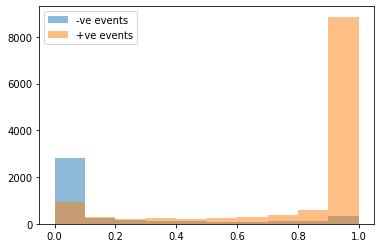

In [86]:
p = lnp_probs_all.detach().cpu().numpy()
y = lnp_true_events_all.detach().cpu().numpy()

plt.hist(p[np.where(y == 0)], alpha=0.5, label='-ve events')
plt.hist(p[np.where(y == 1)], alpha=0.5, label='+ve events')
plt.legend()
plt.show()

In [88]:
file = open('test-data.pkl', 'rb')
data = [pickle.load(file)]
file.close()

model = load_model('fullconvgnp-identity', device=device, working_directory=model_directory)

fcg_logprob, fcg_probs_all, fcg_true_events_all = threshold_estimator(data,
                                                                      model=model,
                                                                      coefficient=1.1,
                                                                      num_samples=128,
                                                                      max_num_context=20,
                                                                      max_num_target=100,
                                                                      num_grid=300,
                                                                      noiseless=True)
np.save('numpy/fcg_logprob.npy', fcg_logprob)
np.save('numpy/fcg_probs_all.npy', fcg_probs_all)
np.save('numpy/fcg_true_events_all.npy', fcg_true_events_all)

In [ ]:
p = fcg_probs_all.detach().cpu().numpy()
y = fcg_true_events_all.detach().cpu().numpy()

plt.hist(p[np.where(y == 0)], alpha=0.5, label='-ve events')
plt.hist(p[np.where(y == 1)], alpha=0.5, label='+ve events')
plt.legend()
plt.show()